# Rock Classification and Description Using Conventional and Multispectral Drone Imagery
***
### Domenico M. Crisafulli, Misael M. Morales, and Carlos Torres-Verdin
#### The University of Texas at Austin, 2025
***

In [58]:
import os, cv2, glob
import numpy as np
import pandas as pd
from time import time
from tqdm import tqdm
from PIL import Image
import scipy.io as sio
import matplotlib.pyplot as plt

from skimage.transform import resize

import keras
import tensorflow as tf
from keras import Model
from keras_cv.losses import FocalLoss
from keras import layers, losses, metrics, optimizers, activations, callbacks

def check_tf_gpu(verbose:bool=True):
    sys_info = tf.sysconfig.get_build_info()
    version, cuda, cudnn = tf.__version__, sys_info["cuda_version"], sys_info["cudnn_version"]
    count = len(tf.config.experimental.list_physical_devices())
    name  = [device.name for device in tf.config.experimental.list_physical_devices('GPU')]
    if verbose:
        print('-'*60)
        print('----------------------- VERSION INFO -----------------------')
        print('TF version: {} | # Device(s) available: {}'.format(version, count))
        print('TF Built with CUDA? {} | CUDA: {} | cuDNN: {}'.format(tf.test.is_built_with_cuda(), cuda, cudnn))
        print(tf.config.list_physical_devices()[0],'\n', tf.config.list_physical_devices())
        print('-'*60+'\n')
    return None
check_tf_gpu()

------------------------------------------------------------
----------------------- VERSION INFO -----------------------
TF version: 2.18.0 | # Device(s) available: 1
TF Built with CUDA? True | CUDA: 12.5.1 | cuDNN: 9
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU') 
 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
------------------------------------------------------------



In [7]:
f_ms_images = os.listdir('data_new/multispectral_camera')
n_ms_images = len(f_ms_images)
print('Number of multispectral camera images:', n_ms_images)

Number of multispectral camera images: 19


Images: (19, 4)


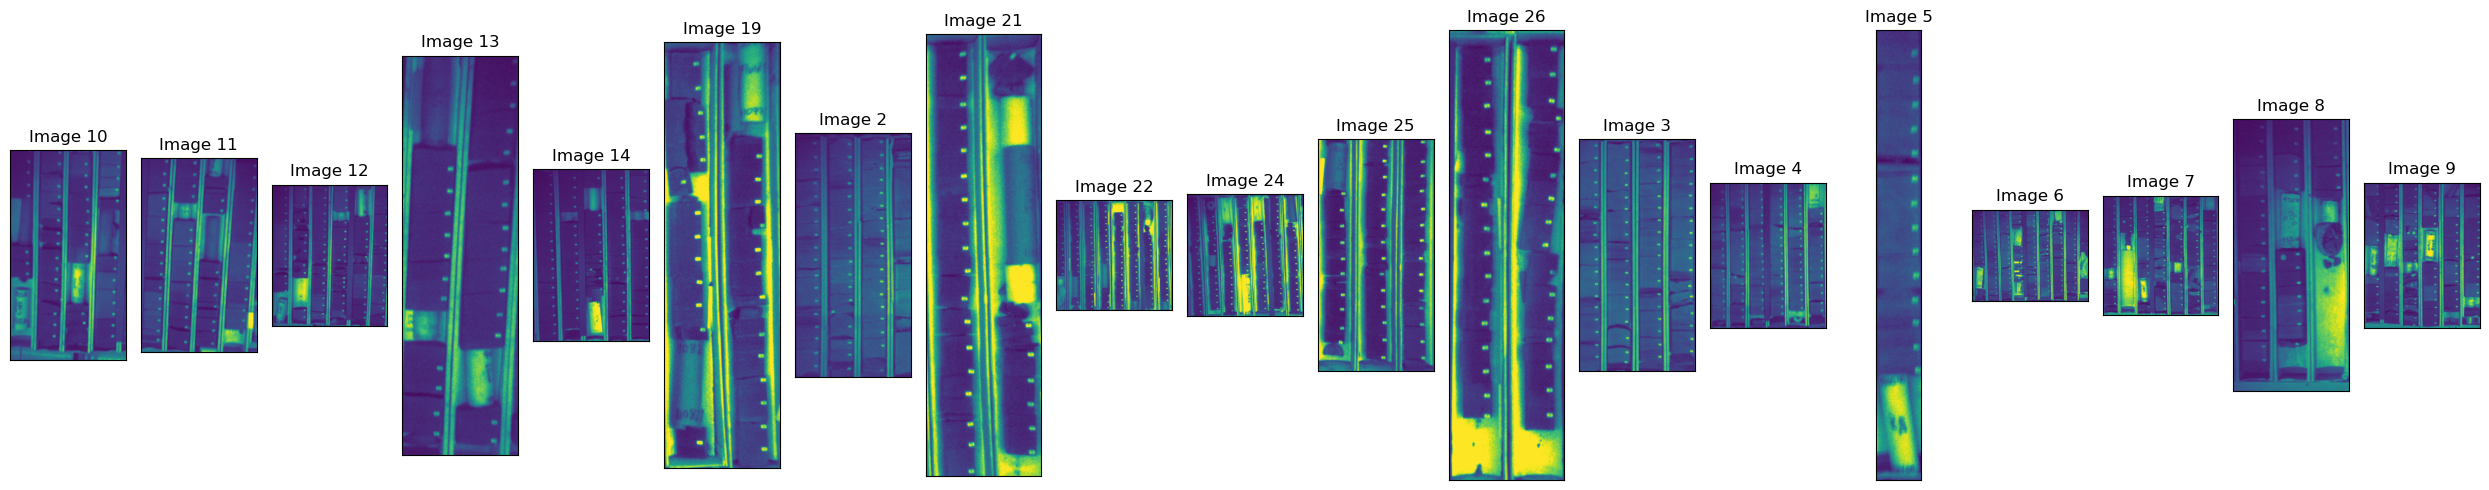

In [8]:
ms_image_names = []
for root, dirs, files in os.walk('data_new/multispectral_camera'):
    for f in files:
        if f.endswith('.png'):
            ms_image_names.append(os.path.join(root, f))
ms_image_names = np.array(ms_image_names).reshape(n_ms_images,4)
print('Images: {}'.format(ms_image_names.shape))

ms_images = []
for i in range(ms_image_names.shape[0]):
    im1 = np.array(Image.open(ms_image_names[i,0]))
    im2 = np.array(Image.open(ms_image_names[i,1]))
    im3 = np.array(Image.open(ms_image_names[i,2]))
    im4 = np.array(Image.open(ms_image_names[i,3]))
    ims = np.dstack((im1,im2,im3,im4))
    #ims_reshaped = resize(ims, (512,512,4), anti_aliasing=True)
    ms_images.append(ims)

fig, axs = plt.subplots(1, n_ms_images, figsize=(25,5))
for i in range(n_ms_images):
    axs[i].imshow(ms_images[i][...,0])
    axs[i].set(xticks=[], yticks=[], title='Image {}'.format(f_ms_images[i]))
plt.tight_layout()
plt.show()

In [ ]:
# Path to the multispectral camera folder
data_path = 'data_new/multispectral_camera'

# Initialize a list to store masks
ms_masks = []

# Get sorted folder names (ensuring they are numerical)
folder_list = sorted([f for f in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, f))], key=lambda x: int(x))

# Iterate over each folder and match with ms_images order
for idx, folder in enumerate(folder_list):
    folder_path = os.path.join(data_path, folder)

    # Dictionary to store masks per channel
    mask_dict = {1: [], 2: [], 3: [], 4: []}

    # Iterate through .npy files in the folder
    for file in sorted(os.listdir(folder_path)):
        if file.endswith('_labeled.npy'):
            parts = file.split('_')  # Extract relevant information
            channel = int(parts[0])  # First number before 'mask'
            label = int(parts[2])  # Second number before 'labeled'

            mask_path = os.path.join(folder_path, file)
            mask_data = np.load(mask_path)  # Load the mask
            
            mask_dict[channel].append((label, mask_data))  # Store as (label, array)

    # Get image dimensions from corresponding ms_images entry
    if idx >= len(ms_images):  # Ensure index is valid
        print(f"Warning: No corresponding image for folder {folder}")
        continue
    
    base_image = ms_images[idx]  # Match order of ms_images with folder index
    img_h, img_w, _ = base_image.shape  # Extract correct dimensions

    # Identify unique labels
    unique_labels = sorted(set(label for ch in mask_dict for label, _ in mask_dict[ch]))
    k = len(unique_labels)

    # Initialize an empty array (h, w, 4, k)
    mask_array = np.zeros((img_h, img_w, 4, k), dtype=np.uint8)

    # Populate the mask array
    for ch in range(1, 5):  # Loop over 4 channels
        for label_idx, label in enumerate(unique_labels):
            # Find corresponding label mask if it exists
            mask_entry = next((m for l, m in mask_dict[ch] if l == label), None)
            if mask_entry is not None:
                # Resize the mask to match image size
                resized_mask = cv2.resize(mask_entry, (img_w, img_h), interpolation=cv2.INTER_NEAREST)
                mask_array[:, :, ch - 1, label_idx] = resized_mask  # Assign resized mask
    
    ms_masks.append(mask_array)  # Store in list

print(f'Loaded {len(ms_masks)} labeled masks.')


Loaded 19 labeled masks.


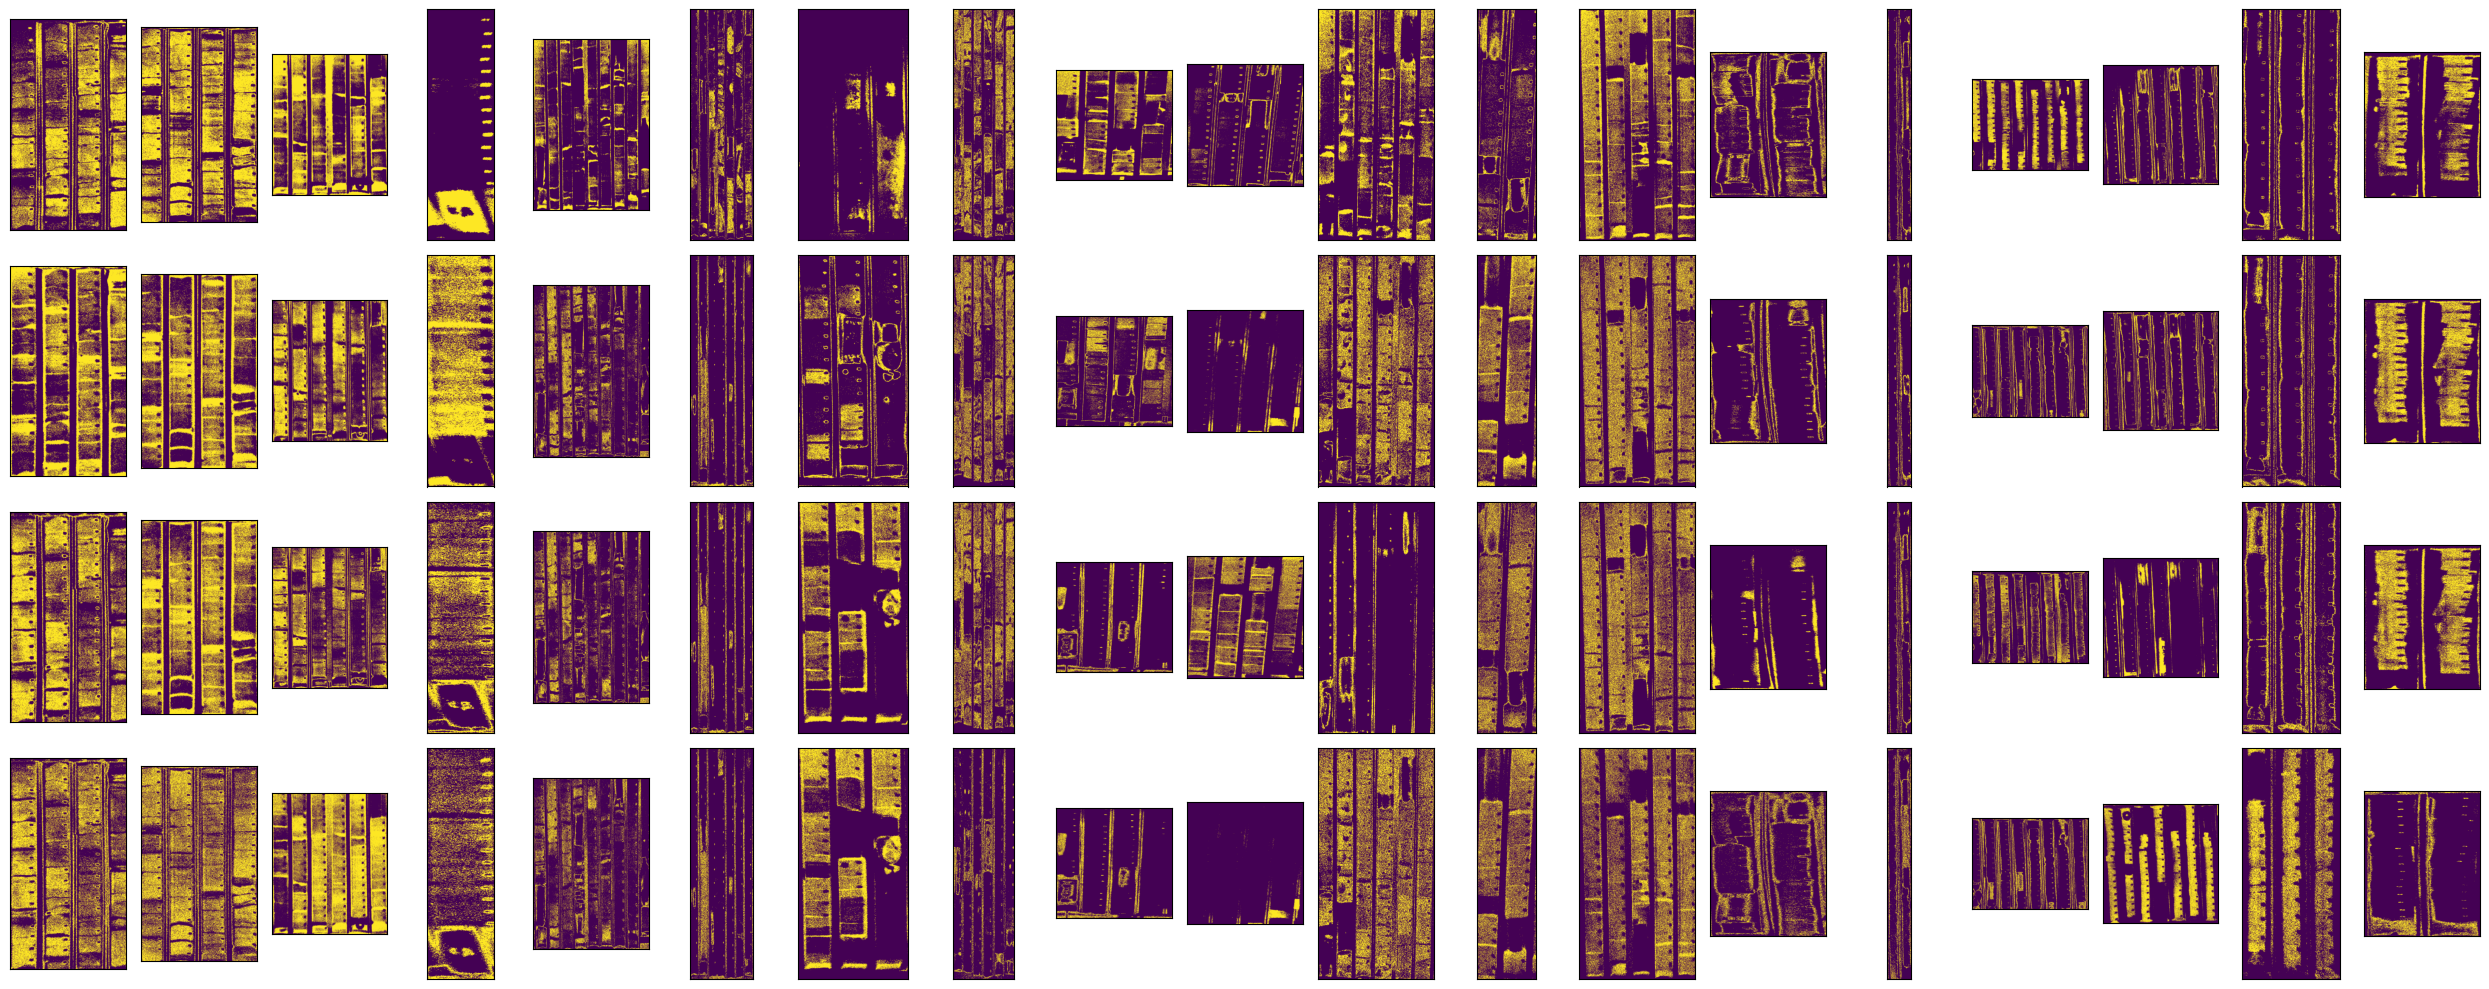

In [23]:
fig, axs = plt.subplots(4, 19, figsize=(25,10))
for i in range(4):
    for j in range(19):
        ax = axs[i,j]
        ax.imshow(ms_masks[j][:,:,i,0])
        ax.set(xticks=[], yticks=[])
plt.tight_layout()
plt.show()

***
## Conventional camera

In [57]:
fnames = []
for root, dirs, files in os.walk('data_new/conventional_camera'):
    for f in files:
        if f.endswith('.png'):
            fnames.append(os.path.join(root, f))

cc_images = []
for i in range(len(fnames)):
    img = np.array(Image.open(fnames[i]))
    cc_images.append(img)
    print(img.shape)

(2400, 1340, 3)
(2600, 1480, 3)
(2650, 2200, 3)
(2850, 730, 3)
(2750, 1975, 3)
(2400, 550, 3)
(2350, 600, 3)
(2450, 2425, 3)
(2450, 2200, 3)
(1750, 800, 3)
(2350, 570, 3)
(2500, 1182, 3)
(2425, 1200, 3)
(2400, 1975, 3)
(2600, 250, 3)
(2500, 3160, 3)
(2520, 2400, 3)
(2500, 1050, 3)
(2450, 2050, 3)


In [434]:
def load_image(fname):
    try:
        img = Image.open(fname).convert("RGB")  # Convert grayscale to RGB
        return np.array(img)
    except Exception as e:
        print(f"Error loading {fname}: {e}")
        return None

In [478]:
def pad_image(image, patch_size=512):
    if len(image.shape) == 3:
        h, w, c = image.shape       
        pad_h = (patch_size - (h % patch_size)) % patch_size
        pad_w = (patch_size - (w % patch_size)) % patch_size
        padded_image = np.pad(image, ((pad_h//2, pad_h//2), (pad_w//2, pad_w//2), (0, 0)), mode='constant', constant_values=0)
    else:
        h, w = image.shape
        pad_h = (patch_size - (h % patch_size)) % patch_size
        pad_w = (patch_size - (w % patch_size)) % patch_size
        padded_image = np.pad(image, ((pad_h//2, pad_h//2), (pad_w//2, pad_w//2)), mode='constant', constant_values=0)
    return padded_image

In [479]:
def crop_into_patches(image, patch_size=512):
    if len(image.shape) == 3:
        h, w, c = image.shape
        patches = []
        for i in range(0, h, patch_size):
            for j in range(0, w, patch_size):
                patch = image[i:i+patch_size, j:j+patch_size, :]
                if patch.shape == (patch_size, patch_size, 3):
                    patches.append(patch)
        return np.array(patches) if patches else None
    else:
        h, w = image.shape
        patches = []
        for i in range(0, h, patch_size):
            for j in range(0, w, patch_size):
                patch = image[i:i+patch_size, j:j+patch_size]
                if patch.shape == (patch_size, patch_size):
                    patches.append(patch)
        return np.array(patches) if patches else None

In [480]:
base_path = "data_new/conventional_camera"
cc_images_patches = []
fnames = []
for root, _, files in os.walk(base_path):
    for f in files:
        if f.lower().endswith(".png"):
            full_path = os.path.join(root, f)
            fnames.append(full_path)
if not fnames:
    print("ERROR: No PNG images were found. Check directory paths!")
else:
    print(f"Found {len(fnames)} PNG images.")

for fname in tqdm(fnames, desc='Processing images'):
    img = load_image(fname)
    if img is None:
        continue

    padded_img = pad_image(img)
    patches = crop_into_patches(padded_img)

    if patches is not None:
        cc_images_patches.append(patches)
    else:
        print(f"WARNING: No valid patches extracted from {fname}")

print("Final shape per subject:")
for i, patches in enumerate(cc_images_patches):
    print(f"Subject {i+1}: {patches.shape}")

Found 19 PNG images.


Processing images: 100%|██████████| 19/19 [00:01<00:00,  9.83it/s]

Final shape per subject:
Subject 1: (15, 512, 512, 3)
Subject 2: (18, 512, 512, 3)
Subject 3: (30, 512, 512, 3)
Subject 4: (12, 512, 512, 3)
Subject 5: (18, 512, 512, 3)
Subject 6: (10, 512, 512, 3)
Subject 7: (10, 512, 512, 3)
Subject 8: (20, 512, 512, 3)
Subject 9: (25, 512, 512, 3)
Subject 10: (8, 512, 512, 3)
Subject 11: (10, 512, 512, 3)
Subject 12: (15, 512, 512, 3)
Subject 13: (12, 512, 512, 3)
Subject 14: (15, 512, 512, 3)
Subject 15: (6, 512, 512, 3)
Subject 16: (35, 512, 512, 3)
Subject 17: (25, 512, 512, 3)
Subject 18: (15, 512, 512, 3)
Subject 19: (25, 512, 512, 3)


In [481]:
folder = "data_new/conventional_camera"
image_files = [f for f in os.listdir(folder) if f.endswith("Drone_Cropped.png")]
image_indices = [int(f.split("Drone_Cropped.png")[0]) for f in image_files]

masks, mask_data = {}, {}
for img_idx in image_indices:
    mask_files = [f for f in os.listdir(folder) if f.startswith('{}mask'.format(img_idx))]
    class_labels = [int(f.split("_")[1]) for f in mask_files]
    for c in class_labels:
        dd = np.load(os.path.join(folder, '{}mask_{}_modified.npy'.format(img_idx, c)))
        if img_idx not in masks:
            masks[img_idx] = {}
        masks[img_idx][c] = dd

for img_idx in image_indices:
    for i in range(10):
        if i not in masks[img_idx]:
            existing_classes = list(masks[img_idx].keys())
            H, W = masks[img_idx][existing_classes[0]].shape
            masks[img_idx][i] = np.zeros((H,W), dtype=np.uint8)
    mask_data[img_idx] = np.stack([masks[img_idx][i] for i in range(10)], axis=-1)

In [482]:
mask_patches = {}
for img_idx in image_indices:
    dd = mask_data[img_idx]
    dd_padded = pad_image(dd)
    p = []
    for i in range(10):
        p.append(crop_into_patches(dd_padded[...,i]))
    mask_patches[img_idx] = np.stack(p, axis=-1)
        
for i, patches in enumerate(mask_patches):
    print(f"Subject {image_indices[i]}: {mask_patches[image_indices[i]].shape}")

Subject 10: (15, 512, 512, 10)
Subject 11: (18, 512, 512, 10)
Subject 12: (30, 512, 512, 10)
Subject 13: (12, 512, 512, 10)
Subject 14: (18, 512, 512, 10)
Subject 19: (10, 512, 512, 10)
Subject 21: (10, 512, 512, 10)
Subject 22: (20, 512, 512, 10)
Subject 24: (25, 512, 512, 10)
Subject 25: (8, 512, 512, 10)
Subject 26: (10, 512, 512, 10)
Subject 2: (15, 512, 512, 10)
Subject 3: (12, 512, 512, 10)
Subject 4: (15, 512, 512, 10)
Subject 5: (6, 512, 512, 10)
Subject 6: (35, 512, 512, 10)
Subject 7: (25, 512, 512, 10)
Subject 8: (15, 512, 512, 10)
Subject 9: (25, 512, 512, 10)


In [ ]:
x_patched = np.concatenate(cc_images_patches, axis=0)
y_patched = np.concatenate(list(mask_patches.values()), axis=0)
print(f"X shape: {x_patched.shape}, Y shape: {y_patched.shape}")

labelmap = np.argmax(y_patched, axis=-1)

X shape: (324, 512, 512, 3), Y shape: (324, 512, 512, 10)


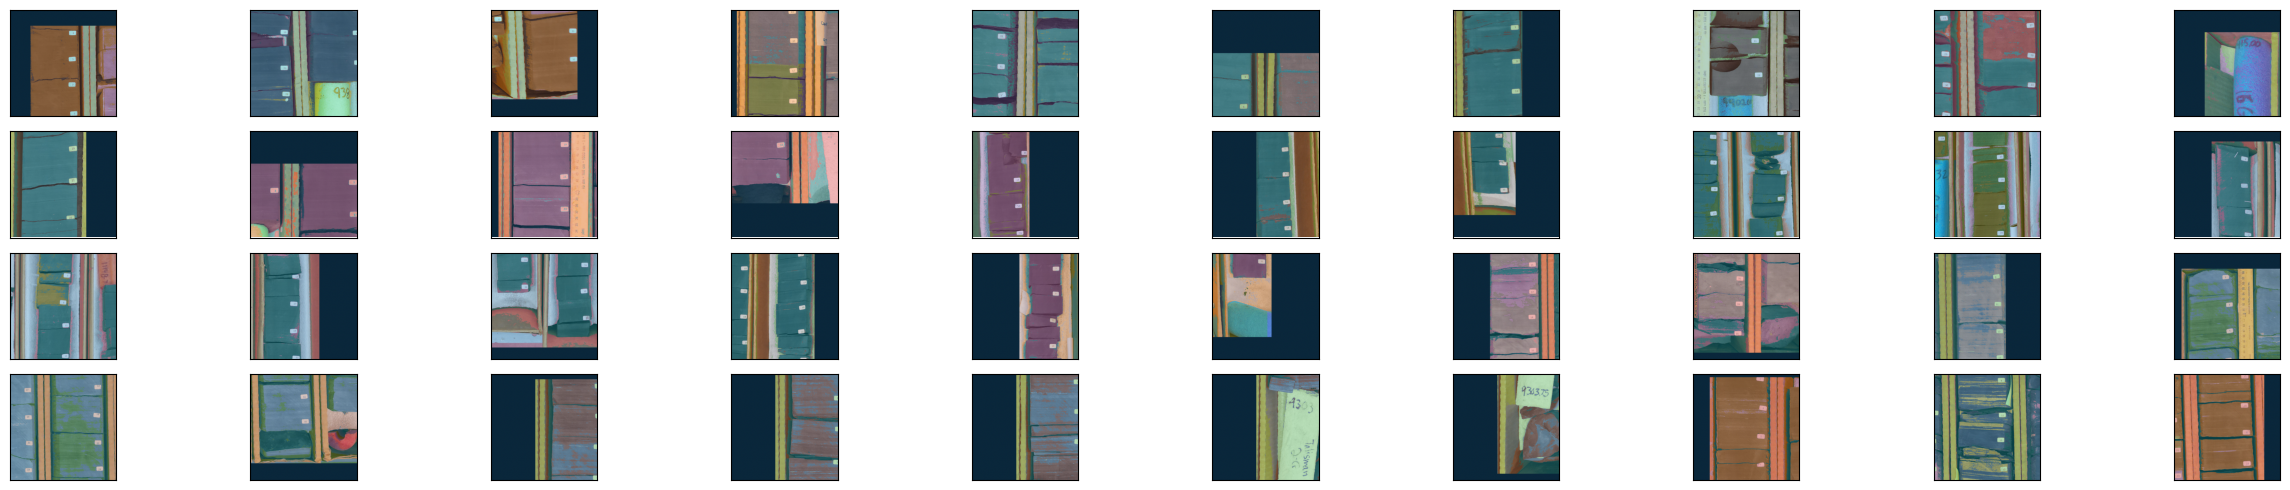

In [489]:
k, mult = 0, 7
fig, axs = plt.subplots(4, 10, figsize=(25,5))
for i in range(4):
    for j in range(10):
        ax = axs[i,j]
        ax.imshow(x_patched[k*mult])
        ax.imshow(labelmap[k*mult], alpha=0.33, cmap='tab10')
        ax.set(xticks=[], yticks=[])
        k += 1
plt.tight_layout()
plt.show()